<a href="https://colab.research.google.com/github/ShivenTripathi/Dimensionality-Reduction-CGM/blob/main/Part_3/ColabNotebooks/DAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/gdrive/MyDrive/CGM
!ls
# !gzip "/content/drive/MyDrive/CGM/dataset/HIGGS_6M.csv.gz" -d "/content/drive/MyDrive/CGM/dataset"

In [ ]:
!pip install -U fastbook

      Successfully uninstalled torch-1.8.0+cu101
  Found existing installation: torchvision 0.9.0+cu101
    Uninstalling torchvision-0.9.0+cu101:
      Successfully uninstalled torchvision-0.9.0+cu101
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import fastbook
fastbook.setup_book()
from fastai.metrics import mse
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from fastai import learner
from fastai.data import core
import time
from fastai.callback import schedule
import os
import numpy as np
from scipy import stats
import seaborn as sns

In [ ]:
df=pd.read_csv("dataset/HIGGS_6M.csv")

In [ ]:
dataset=df.to_numpy()

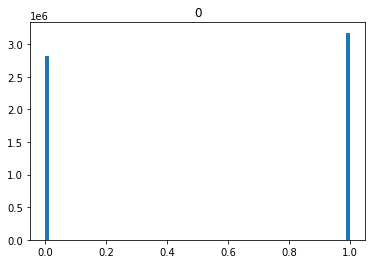

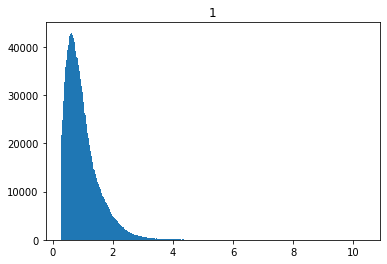

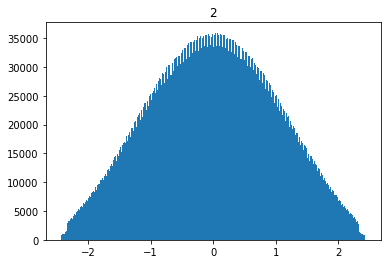

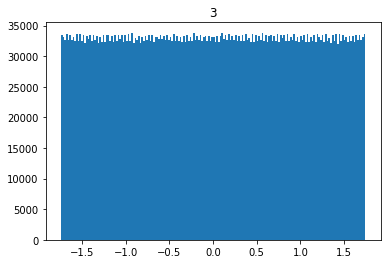

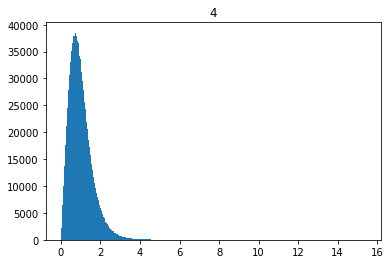

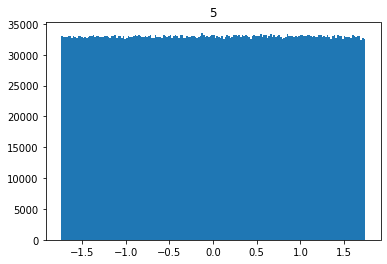

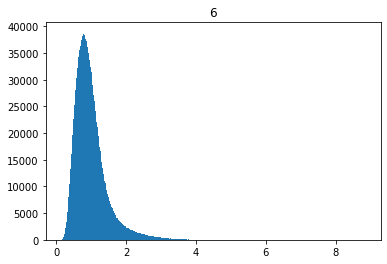

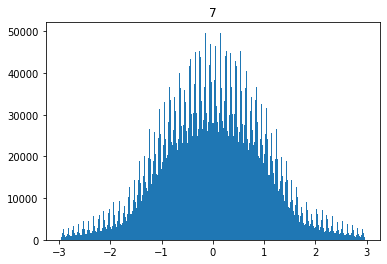

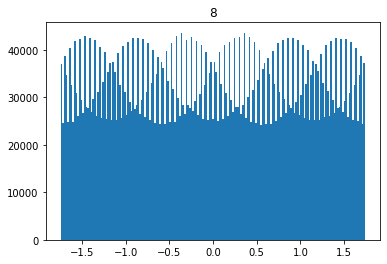

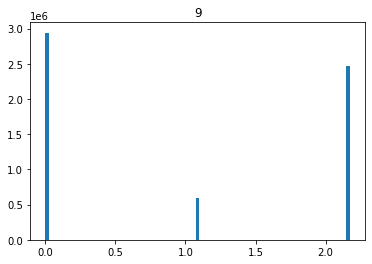

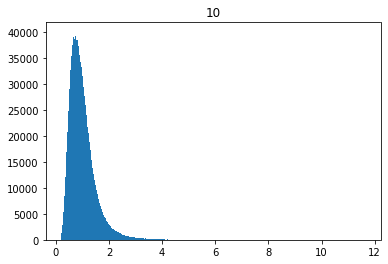

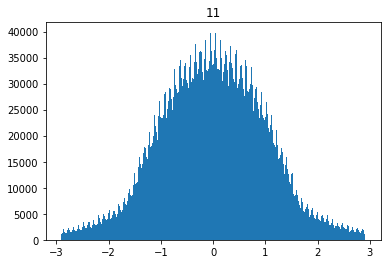

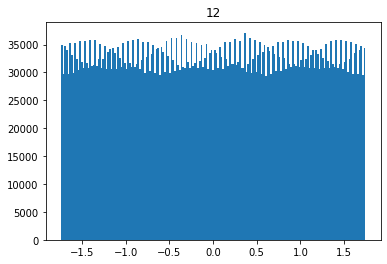

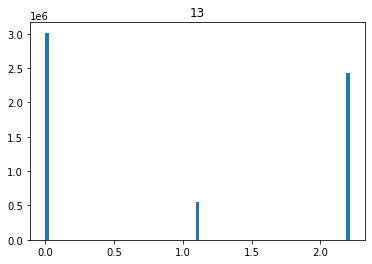

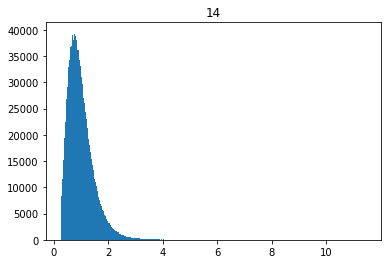

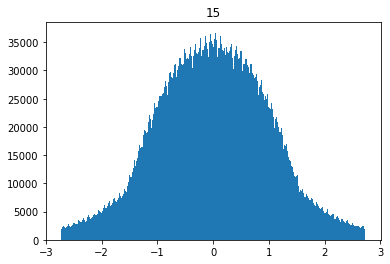

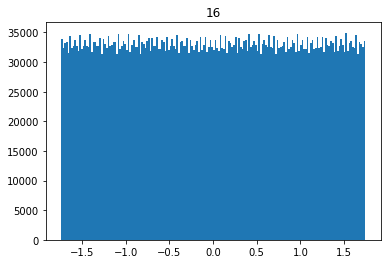

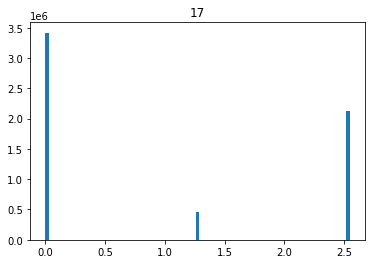

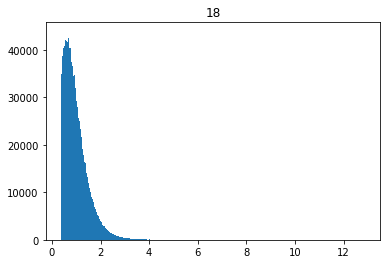

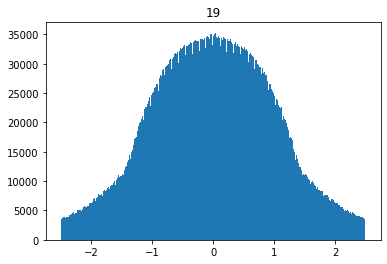

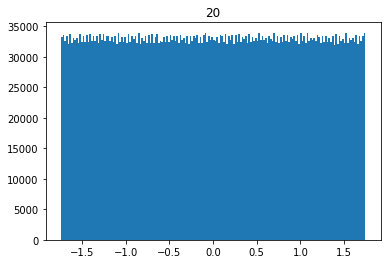

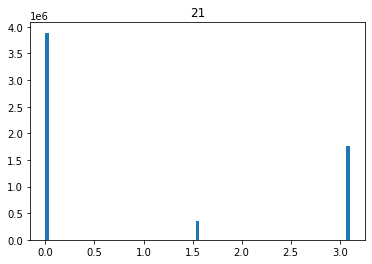

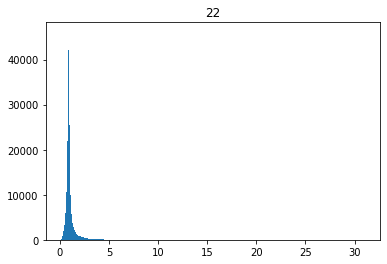

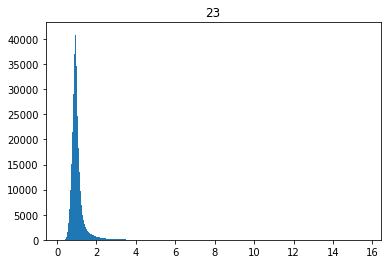

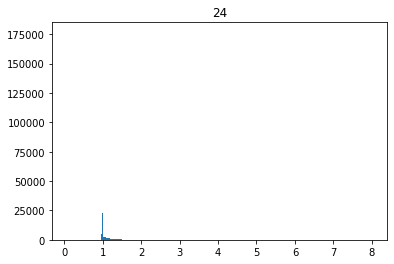

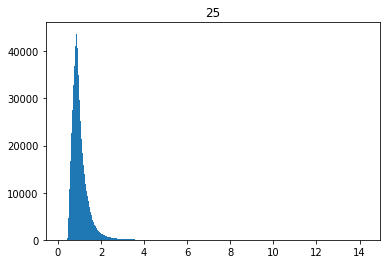

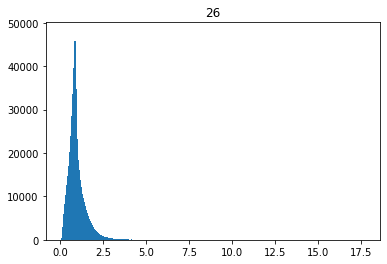

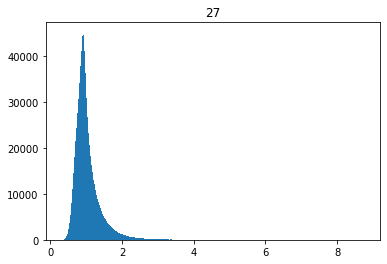

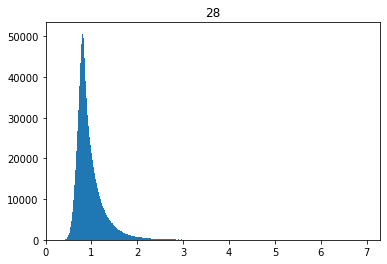

In [ ]:
for i in range(29):
  plt.hist(dataset[:,i],bins='auto')
  plt.title(str(i))
  plt.show()

# Preprocessing

* Log Transform
* Standard Scaling
* Min Max Scaling
* Rounding categorical features to integers

You can skip training, jump to the last cell to load from drive

In [ ]:
mod_dataset=dataset
logtransform=[1,4,6,10,14,18,22,23,24,25,26,27,28]
for index in logtransform:
  mod_dataset[:,index]=np.log(mod_dataset[:,index])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

scaler = StandardScaler()
categorical=[0,9,13,17,21]
non_categorical=[]
for i in range(29):
  if i not in categorical:
    non_categorical.append(i)
print(non_categorical)
for index in non_categorical:
  mod_dataset[:,index]=scaler.fit_transform(mod_dataset[:,index].reshape(-1,1)).reshape(-1)

scaler = MinMaxScaler()
for index in non_categorical:
  mod_dataset[:,index]=scaler.fit_transform(mod_dataset[:,index].reshape(-1,1)).reshape(-1)

[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28]


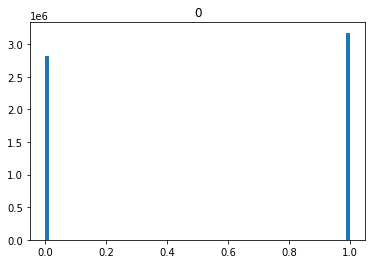

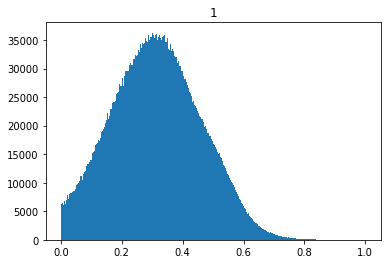

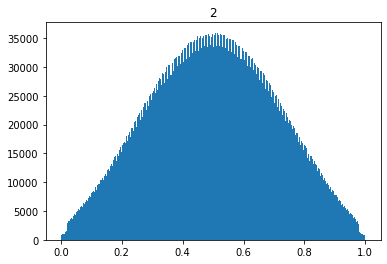

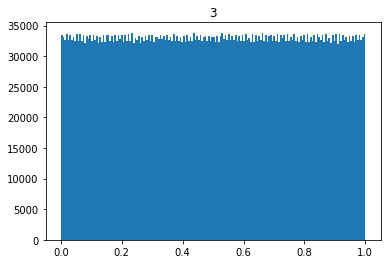

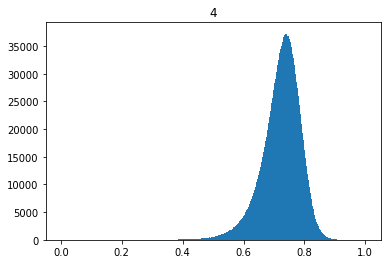

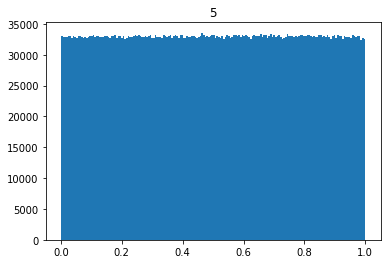

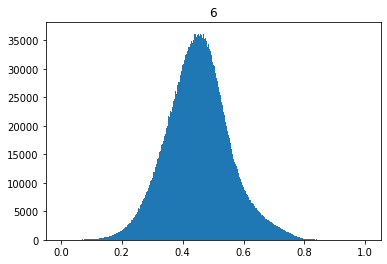

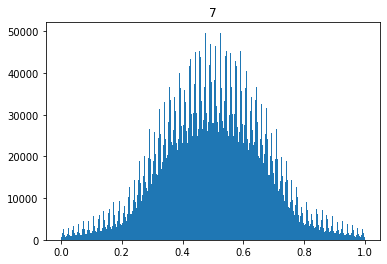

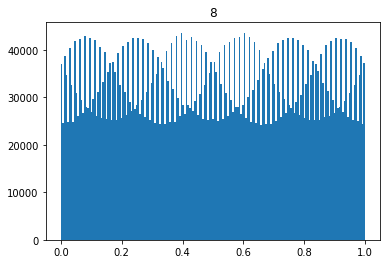

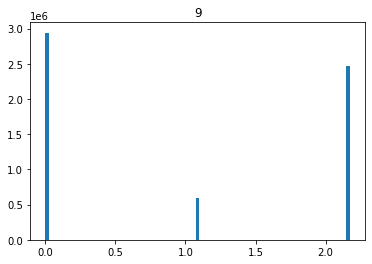

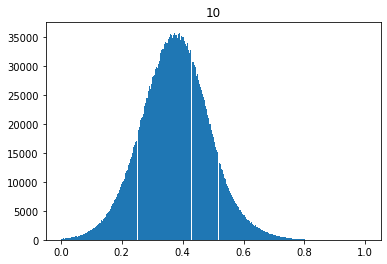

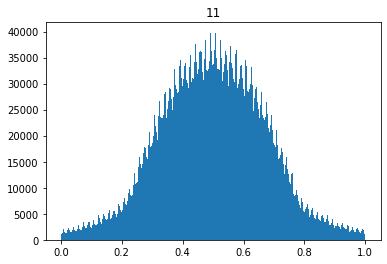

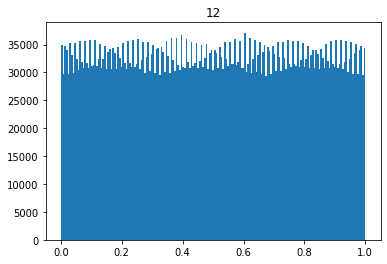

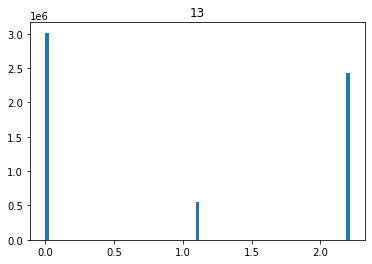

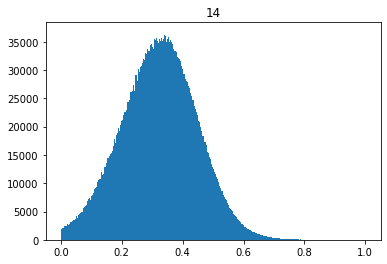

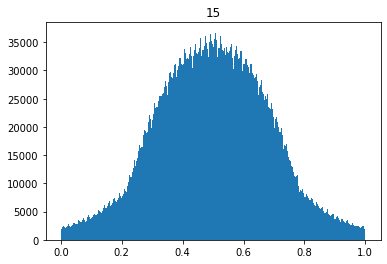

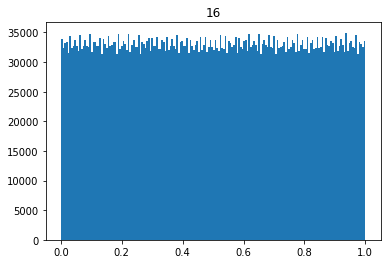

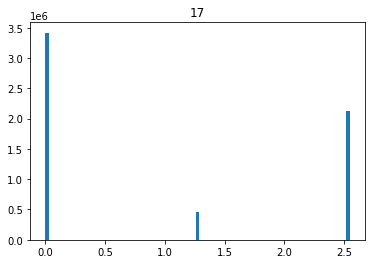

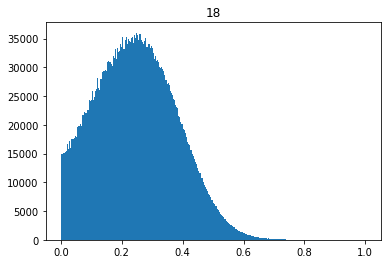

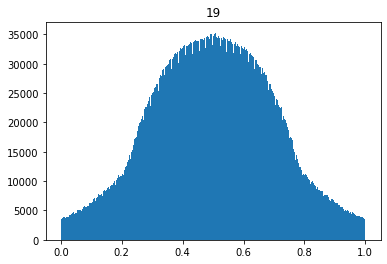

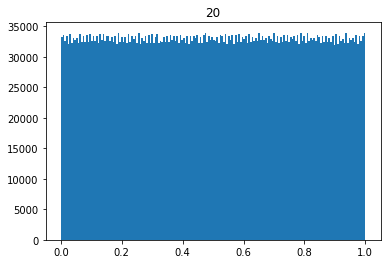

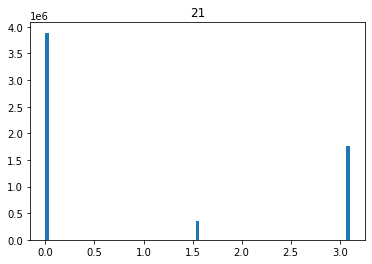

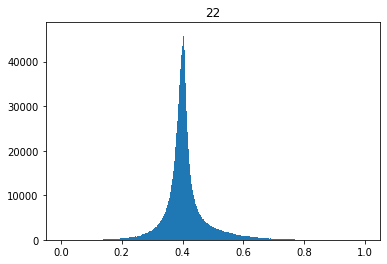

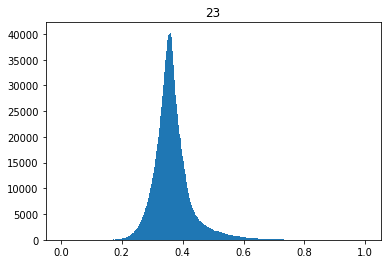

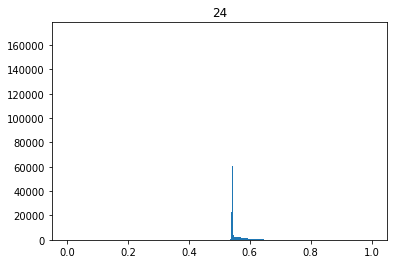

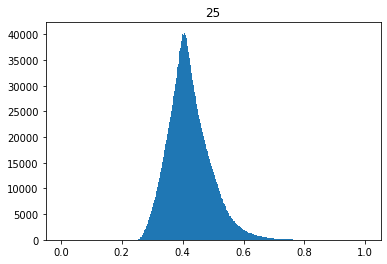

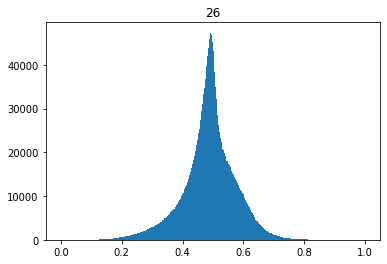

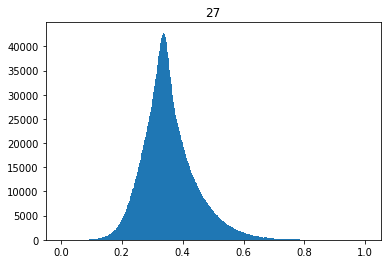

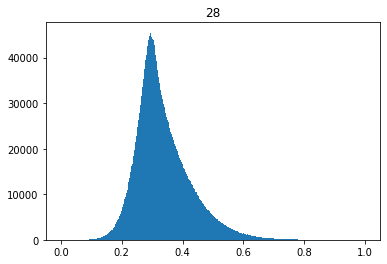

In [ ]:
for i in range(29):
  plt.hist(mod_dataset[:,i],bins='auto')
  plt.title(str(i))
  plt.show()

In [ ]:
for index in categorical:
  mod_dataset[:,index]=mod_dataset[:,index].astype(int)

In [ ]:
X = mod_dataset[:,1:]
Y = mod_dataset[:,0].astype(int)
print(X[0],Y[0])
print(np.shape(X),np.shape(X[0]),np.shape(Y),np.shape(Y[0]))

[0.32890303 0.56759999 0.6030047  0.7796093  0.41033889 0.49819829 0.40613539 0.04393373 2.         0.35392154 0.46332112 0.86453768 2.         0.16984222 0.26892296 0.70997375 0.         0.0245159
 0.27192399 0.49966728 0.         0.21731784 0.32833051 0.54171222 0.42770875 0.47117561 0.35743408 0.28916102] 1
(5999999, 28) (28,) (5999999,) ()


In [ ]:
del mod_dataset

In [ ]:
train, test, y_train, y_test = train_test_split(X,Y, test_size=0.01)
train_x = train
test_x = test
train_y = train_x  
test_y = test_x


train_ds = TensorDataset(torch.tensor(train_x, dtype=torch.float), torch.tensor(train_y, dtype=torch.float))
test_ds = TensorDataset(torch.tensor(test_x, dtype=torch.float), torch.tensor(test_y, dtype=torch.float))

bs = 256

train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=bs * 2)
dls = core.DataLoaders(train_dl, test_dl)

# Modelling a 5 layer DAE on this processed dataset



In [ ]:
class AE_4D_300_LeakyReLU(nn.Module):
    def __init__(self, n_features=28,bottle_neck=8):
        super(AE_4D_300_LeakyReLU, self).__init__()
        self.en1 = nn.Linear(n_features, 300)
        self.en2 = nn.Linear(300, 200)
        self.en3 = nn.Linear(200, 100)
        self.en4 = nn.Linear(100,50)
        self.en5 = nn.Linear(50, bottle_neck)
        self.de1 = nn.Linear(bottle_neck, 50)
        self.de2 = nn.Linear(50, 100)
        self.de3 = nn.Linear(100, 200)
        self.de4 = nn.Linear(200,300)
        self.de5 = nn.Linear(300, n_features)
        self.tanh = nn.Tanh()

    def encode(self, x):
        return self.en5(self.tanh(self.en4(self.tanh(self.en3(self.tanh(self.en2(self.tanh(self.en1(x)))))))))

    def decode(self, x):
        return self.de5(self.tanh(self.de4(self.tanh(self.de3(self.tanh(self.de2(self.tanh(self.de1(self.tanh(x))))))))))

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

model = AE_4D_300_LeakyReLU()
model.to('cpu')

AE_4D_300_LeakyReLU(
  (en1): Linear(in_features=28, out_features=300, bias=True)
  (en2): Linear(in_features=300, out_features=200, bias=True)
  (en3): Linear(in_features=200, out_features=100, bias=True)
  (en4): Linear(in_features=100, out_features=50, bias=True)
  (en5): Linear(in_features=50, out_features=8, bias=True)
  (de1): Linear(in_features=8, out_features=50, bias=True)
  (de2): Linear(in_features=50, out_features=100, bias=True)
  (de3): Linear(in_features=100, out_features=200, bias=True)
  (de4): Linear(in_features=200, out_features=300, bias=True)
  (de5): Linear(in_features=300, out_features=28, bias=True)
  (tanh): Tanh()
)

In [ ]:
loss_func = nn.MSELoss()

#bn_wd = False  # Don't use weight decay for batchnorm layers
true_wd = True  # weight decay will be used for all optimizers
wd = 1e-6

recorder = learner.Recorder()
learn = learner.Learner(dls, model=model, wd=wd, loss_func=loss_func, cbs=recorder)

Learning rate with the minimum loss: 0.0019054606556892395
Learning rate with the steepest gradient: 0.0006918309954926372


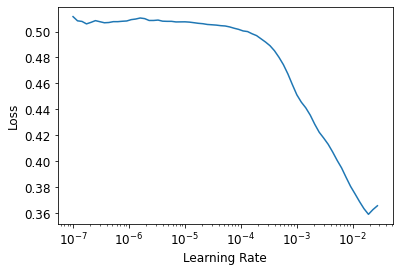

In [ ]:
lr_min, lr_steep = learn.lr_find()

print('Learning rate with the minimum loss:', lr_min)
print('Learning rate with the steepest gradient:', lr_steep)

In [ ]:
start = time.perf_counter() 
learn.fit_one_cycle(n_epoch=6,lr_max=lr_min)
end = time.perf_counter() 
delta_t = end - start
print('Training took', delta_t, 'seconds')

epoch,train_loss,valid_loss,time
0,0.006768,0.006965,04:59
0,0.006768,0.006965,04:59
1,0.005052,0.005163,04:57
1,0.005052,0.005163,04:57
2,0.004405,0.004531,05:06
2,0.004405,0.004531,05:06
3,0.004100,0.004148,04:58
3,0.004100,0.004148,04:58
4,0.003793,0.003810,04:57
4,0.003793,0.003810,04:57


Training took 1794.9892121070002 seconds


(#1) [0.0036510382778942585]

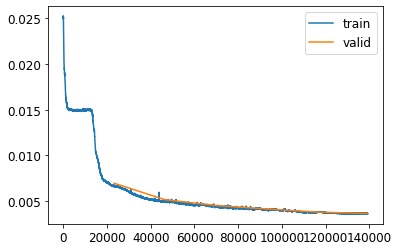

In [ ]:
recorder.plot_loss()
learn.validate()

In [ ]:
save_dir = "dae_model"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [ ]:
torch.save(model.state_dict(), "dae_model/model.pth")

# Load model from Drive

In [ ]:
model_inf = AE_4D_300_LeakyReLU()
model_inf.to('cpu')
model_inf.load_state_dict(torch.load("dae_model/model.pth"))

<All keys matched successfully>

In [ ]:
data = torch.tensor(X[:10**4], dtype=torch.float)

pred = model_inf(data)
pred = pred.detach().numpy()
data = data.detach().numpy()

data_df = pd.DataFrame(data)
pred_df = pd.DataFrame(pred)

# Results 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


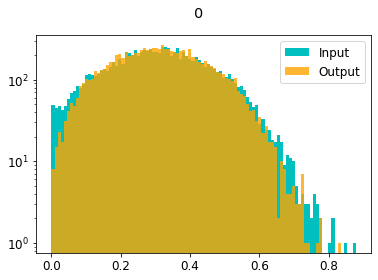

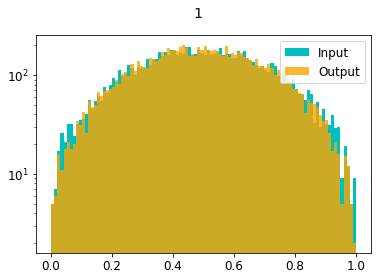

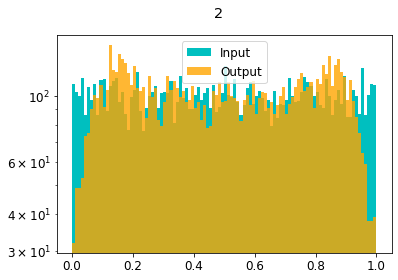

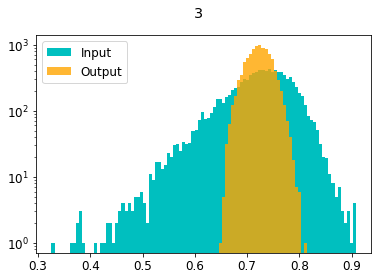

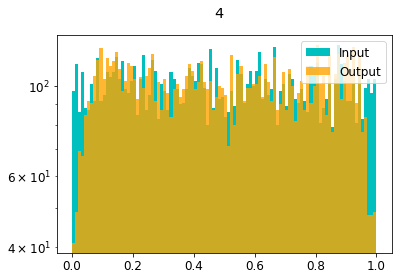

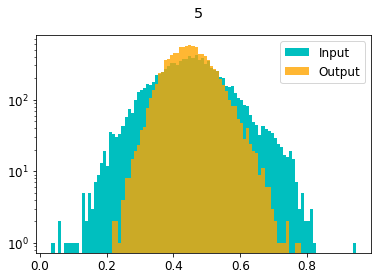

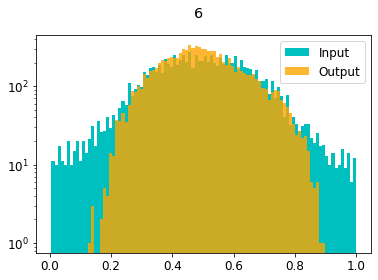

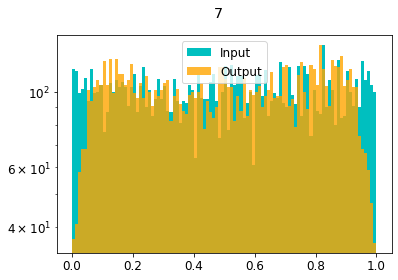

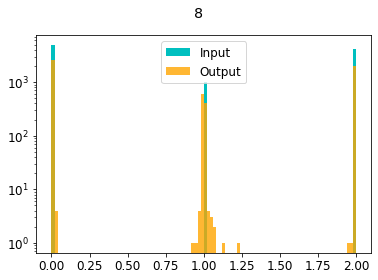

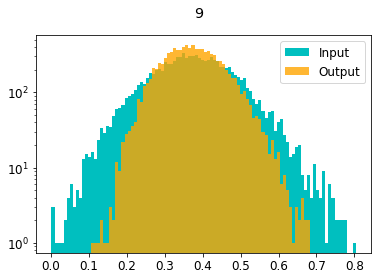

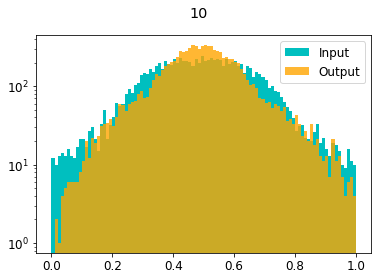

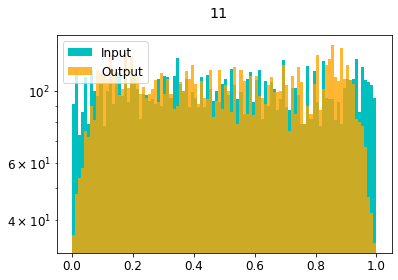

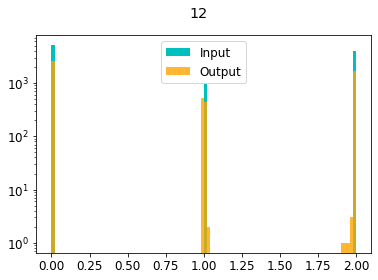

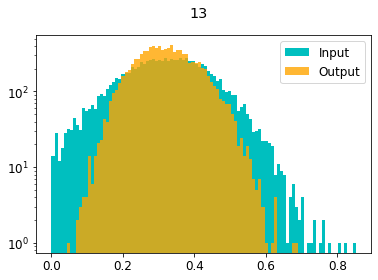

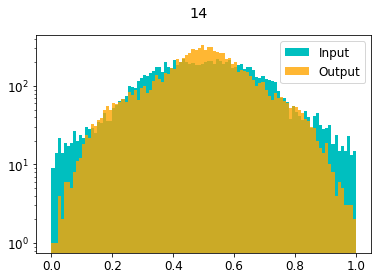

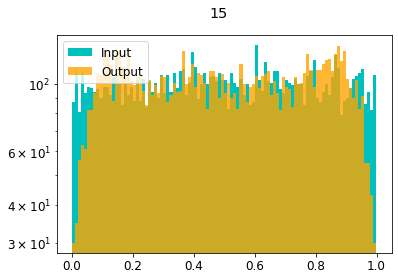

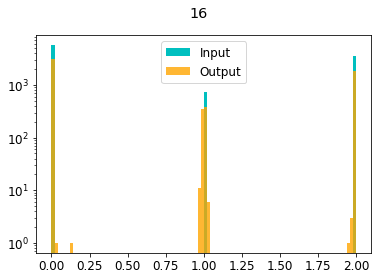

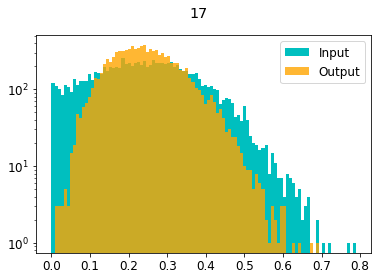

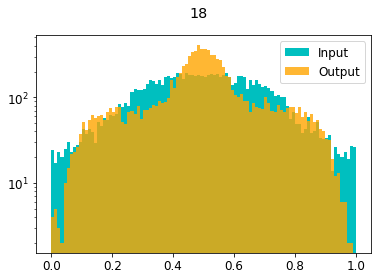

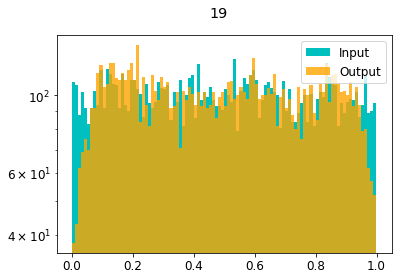

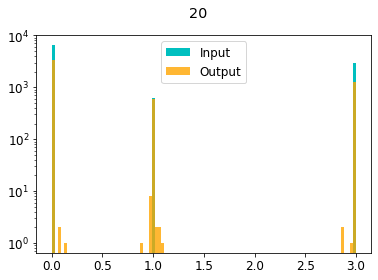

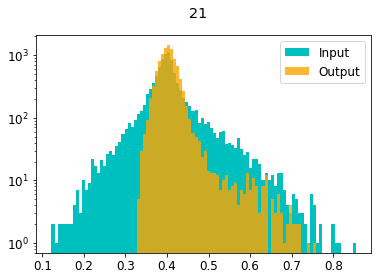

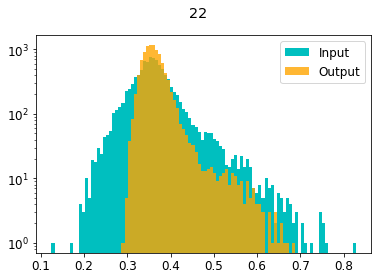

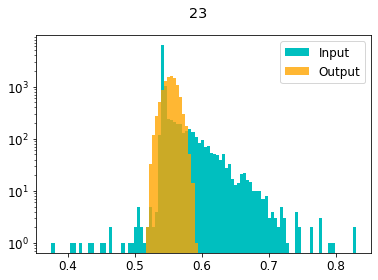

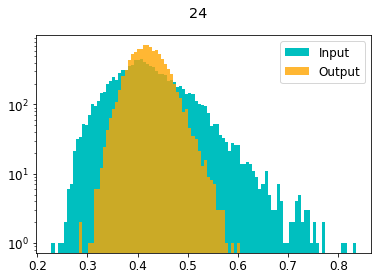

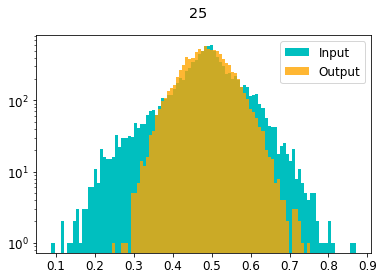

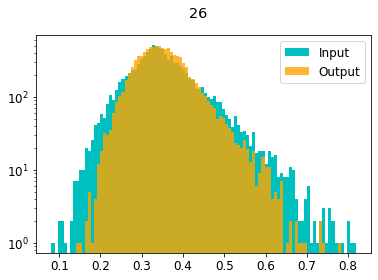

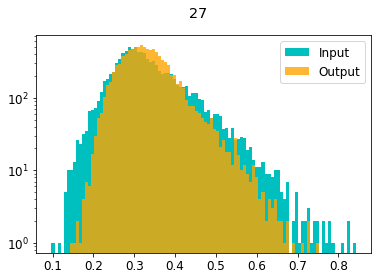

In [ ]:
alph = 0.8
n_bins = 100
colors = ['orange', 'c']

for kk in np.arange(28):
    plt.figure()
    n_hist_data, bin_edges, _ = plt.hist(data[:, kk], color=colors[1], label='Input', alpha=1, bins=n_bins)
    n_hist_pred, _, _ = plt.hist(pred[:, kk], color=colors[0], label='Output', alpha=alph, bins=bin_edges)
    plt.suptitle(str(kk))
    plt.yscale('log')
    # if True:
    #     plt.savefig(os.path.join(save_dir,str(kk)+'.png'))
    plt.legend()